In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import nltk
from gensim.models import KeyedVectors
from collections import Counter

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
w2v = KeyedVectors.load_word2vec_format("PubMed-and-PMC-w2v.bin", binary=True)
embed_dim = w2v.vector_size

In [41]:
data_path = './data/'
df_data = pd.read_csv(data_path + 'data_processed.csv')
df_data['TOKENS'] = df_data['CLEAN_TEXT'].apply(nltk.word_tokenize)

In [42]:
counter = Counter()
for tokens in df_data['TOKENS']:
    counter.update([t.lower() for t in tokens])

vocab = {'<PAD>': 0, '<UNK>': 1}
for word in counter:
    vocab[word] = len(vocab)

In [43]:
embedding_matrix = np.random.uniform(-0.25, 0.25, (len(vocab), embed_dim)).astype(np.float32)
for word, idx in vocab.items():
    if word in w2v:
        embedding_matrix[idx] = w2v[word]

In [44]:
def tokens_to_ids(tokens):
    return [vocab.get(t.lower(), vocab['<UNK>']) for t in tokens]

In [45]:
class TokenDataset(Dataset):
    def __init__(self, token_lists, labels):
        self.data = [tokens_to_ids(tokens) for tokens in token_lists]
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [46]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    max_len = min(max(len(seq) for seq in sequences), 512)
    padded = [seq[:max_len] + [0]*(max_len - len(seq)) for seq in sequences]
    return torch.tensor(padded), torch.tensor(labels)

In [47]:
def generate_balanced_dataset(df_data, label_col='GEN_RE', mode='undersample'):
    if label_col == 'GEN_RE':
        pos_idx = np.where(df_data['GEN_RE'] == 1)[0]
        neg_idx = np.where(df_data['GEN_RE'] == 0)[0]
    elif label_col == '30_RE':
        pos_idx = np.where(df_data['30_RE'] == 1)[0]  
        neg_idx = np.where(df_data['30_RE'] == 0)[0]  
    else:
        raise ValueError("label_col should be 'GEN_RE' or '30_RE'")

    if mode == 'undersample':
        neg_sample = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
        all_idx = list(pos_idx) + list(neg_sample)
        neg_sample_idx = neg_sample 
    elif mode == 'oversample':
        pos_sample = np.random.choice(pos_idx, size=len(neg_idx), replace=True)
        all_idx = list(neg_idx) + list(pos_sample)
        neg_sample_idx = None 
    else:
        raise ValueError("mode should be 'undersample' or 'oversample'")
    tokens_all = df_data.iloc[all_idx]['TOKENS'].tolist()
    labels = df_data.iloc[all_idx][label_col].tolist()
    return tokens_all, labels, neg_sample_idx

In [48]:
def augment_training_data(x_train_tokens, y_train, df_data, neg_sample_idx, label_col):
    if neg_sample_idx is None:
        print(f"[{label_col}] Skipped augmentation because neg_sample_idx is None.")
        return x_train_tokens, y_train

    num_neg = len(x_train_tokens) // 2
    add_neg_idx = np.random.choice(neg_sample_idx, size=min(num_neg, len(neg_sample_idx)), replace=False)
    add_tokens_neg = df_data.iloc[add_neg_idx]['TOKENS'].tolist()
    add_labels_neg = df_data.iloc[add_neg_idx][label_col].tolist()

    pos_idx = [i for i, y in enumerate(y_train) if y == 1]
    add_tokens_pos = [x_train_tokens[i] for i in pos_idx]
    add_labels_pos = [y_train[i] for i in pos_idx]

    x_train_tokens += add_tokens_neg + add_tokens_pos
    y_train += add_labels_neg + add_labels_pos

    return x_train_tokens, y_train

In [49]:
class TransformerClassifier(nn.Module): 
    def __init__(self, embedding_matrix, num_heads=8, num_layers=3, num_classes=2, dropout=0.2, freeze=True):
        super().__init__()
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix),
            freeze=freeze
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, 512, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
            dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        seq_len = x.size(1)
        x = self.embedding(x) + self.pos_embedding[:, :seq_len, :]
        x = self.transformer(x)
        x = self.dropout(x.mean(dim=1))
        return self.fc(x)

In [50]:
def train_model(model, loader, optimizer, criterion, loss_list, acc_list):
    model.train()
    total_loss = 0
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    loss_list.append(total_loss / len(loader))
    acc_list.append(correct / total)
def evaluate(model, loader):
    model.eval()
    preds, trues, probs = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            prob = torch.softmax(out, dim=1)[:, 1].cpu().tolist()
            pred = torch.argmax(out, dim=1).cpu().tolist()
            probs.extend(prob)
            preds.extend(pred)
            trues.extend(y.tolist())
    return accuracy_score(trues, preds), f1_score(trues, preds, zero_division=0), precision_score(trues, preds, zero_division=0), recall_score(trues, preds, zero_division=0), trues, preds, probs

def print_test_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('Test Results:')
    print(f'Test Accuracy: {acc:.4f}')
    print(f'Test Precision: {prec:.4f}')
    print(f'Test Recall: {rec:.4f}')
    print(f'Test F1 Score: {f1:.4f}\n')

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
tokens, labels, neg_idx = generate_balanced_dataset(df_data, label_col='GEN_RE', mode='undersample')
print(f"[GEN_RE Before Augmentation] Positive Ratio: {sum(labels) / len(labels):.2f}")
x_train_temp, x_test, y_train_temp, y_test = train_test_split(tokens, labels, test_size=0.1, shuffle=True, random_state=42)
x_train_temp, x_val, y_train_temp, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.1, shuffle=True, random_state=42)
x_train, y_train = augment_training_data(x_train_temp, y_train_temp, df_data, neg_idx, 'GEN_RE')
print(f"[GEN_RE After Augmentation] Positive Ratio: {sum(y_train) / len(y_train):.2f}")

train_loader = DataLoader(TokenDataset(x_train, y_train), batch_size=55, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TokenDataset(x_val, y_val), batch_size=55, collate_fn=collate_fn)
test_loader = DataLoader(TokenDataset(x_test, y_test), batch_size=55, collate_fn=collate_fn)

model_genre = TransformerClassifier(
    embedding_matrix=embedding_matrix,
    num_heads=4,
    num_layers=2,
    num_classes=2,
    dropout=0.167,
    freeze=False
).to(device)

optimizer = optim.Adam(model_genre.parameters(), lr=0.000211)

criterion = nn.CrossEntropyLoss()

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

best_val_f1 = 0
patience = 5
counter = 0

for epoch in range(30):
    train_model(model_genre, train_loader, optimizer, criterion, train_loss_list, train_acc_list)
    acc, f1, _, _, _, preds, _ = evaluate(model_genre, val_loader)
    val_loss_list.append(1 - f1)
    val_acc_list.append(acc)
    print(f"GEN_RE Epoch {epoch+1}: Val Acc={acc:.4f}, F1={f1:.4f}")
    if f1 > best_val_f1:
        best_val_f1 = f1
        counter = 0
        best_model_state = model_genre.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model_genre.load_state_dict(best_model_state)
print("\nFinal Evaluation on Test Set:")

[GEN_RE Before Augmentation] Positive Ratio: 0.50
[GEN_RE After Augmentation] Positive Ratio: 0.50
GEN_RE Epoch 1: Val Acc=0.5878, F1=0.5394
GEN_RE Epoch 2: Val Acc=0.6395, F1=0.6608
GEN_RE Epoch 3: Val Acc=0.6661, F1=0.7201
GEN_RE Epoch 4: Val Acc=0.7163, F1=0.7228
GEN_RE Epoch 5: Val Acc=0.7241, F1=0.7007
GEN_RE Epoch 6: Val Acc=0.7053, F1=0.6371
GEN_RE Epoch 7: Val Acc=0.7727, F1=0.7650
GEN_RE Epoch 8: Val Acc=0.7602, F1=0.7203
GEN_RE Epoch 9: Val Acc=0.7774, F1=0.7482
GEN_RE Epoch 10: Val Acc=0.7743, F1=0.7677
GEN_RE Epoch 11: Val Acc=0.7257, F1=0.6628
GEN_RE Epoch 12: Val Acc=0.7367, F1=0.6757
GEN_RE Epoch 13: Val Acc=0.7429, F1=0.6846
GEN_RE Epoch 14: Val Acc=0.7853, F1=0.7558
GEN_RE Epoch 15: Val Acc=0.7618, F1=0.7196
Early stopping at epoch 15

Final Evaluation on Test Set:


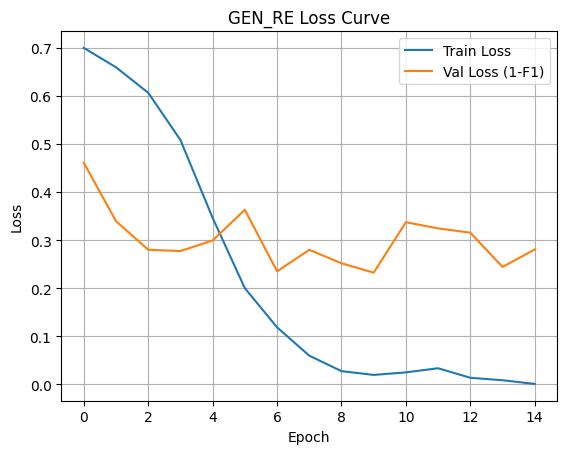

In [51]:
plt.figure()
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss (1-F1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GEN_RE Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

Test Results:
Test Accuracy: 0.7278
Test Precision: 0.8577
Test Recall: 0.5632
Test F1 Score: 0.6799


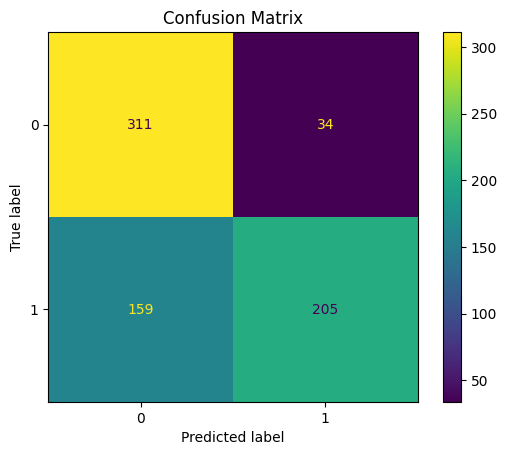

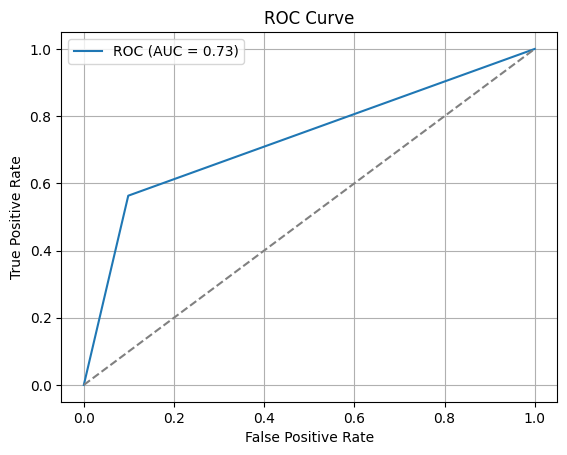

In [52]:
_, _, _, _, y_true_test, y_pred_test, _ = evaluate(model_genre, test_loader)
print_test_metrics(y_true_test, y_pred_test)

In [34]:
plt.figure()
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GEN_RE Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()
_, _, _, _, y_true_test, y_pred_test, _ = evaluate(model_genre, test_loader)
print_test_metrics(y_true_test, y_pred_test)
tokens, labels, neg_idx = generate_balanced_dataset(df_data, label_col='30_RE', mode='oversample')
print(f"[30_RE Before Augmentation] Positive Ratio: {sum(labels) / len(labels):.2f}")

x_train_temp, x_test, y_train_temp, y_test = train_test_split(tokens, labels, test_size=0.1, shuffle=True, random_state=42)
x_train_temp, x_val, y_train_temp, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.1, shuffle=True, random_state=42)

x_train, y_train = augment_training_data(x_train_temp, y_train_temp, df_data, neg_idx, '30_RE')
print(f"[30_RE After Augmentation] Positive Ratio: {sum(y_train) / len(y_train):.2f}")
train_loader = DataLoader(TokenDataset(x_train, y_train), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TokenDataset(x_val, y_val), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(TokenDataset(x_test, y_test), batch_size=32, collate_fn=collate_fn)

model_30re = TransformerClassifier( 
    embedding_matrix=embedding_matrix,
    num_heads=10,        
    num_layers=3,
    num_classes=2,
    dropout=0.2,
    freeze=False
).to(device)
optimizer = optim.Adam(model_30re.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

best_val_f1 = 0
patience = 5
counter = 0

for epoch in range(20):
    train_model(model_30re, train_loader, optimizer, criterion, train_loss_list, train_acc_list)
    acc, f1, _, _, _, preds, _ = evaluate(model_30re, val_loader)
    val_loss_list.append(1 - f1)
    val_acc_list.append(acc)
    print(f"30_RE Epoch {epoch+1}: Val Acc={acc:.4f}, F1={f1:.4f}")
    if f1 > best_val_f1:
        best_val_f1 = f1
        counter = 0
        best_model_state = model_30re.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model_30re.load_state_dict(best_model_state)
print("\nFinal Evaluation on 30_RE Test Set:")

[30_RE Before Augmentation] Positive Ratio: 0.50
[30_RE] Skipped augmentation because neg_sample_idx is None.
[30_RE After Augmentation] Positive Ratio: 0.50
30_RE Epoch 1: Val Acc=0.5897, F1=0.4718
30_RE Epoch 2: Val Acc=0.8037, F1=0.8052
30_RE Epoch 3: Val Acc=0.8237, F1=0.8441
30_RE Epoch 4: Val Acc=0.9644, F1=0.9637
30_RE Epoch 5: Val Acc=0.9627, F1=0.9624
30_RE Epoch 6: Val Acc=0.9744, F1=0.9736
30_RE Epoch 7: Val Acc=0.9657, F1=0.9641
30_RE Epoch 8: Val Acc=0.9783, F1=0.9778
30_RE Epoch 9: Val Acc=0.9700, F1=0.9697
30_RE Epoch 10: Val Acc=0.9683, F1=0.9680
30_RE Epoch 11: Val Acc=0.9761, F1=0.9757
30_RE Epoch 12: Val Acc=0.9670, F1=0.9668
30_RE Epoch 13: Val Acc=0.9766, F1=0.9761
Early stopping at epoch 13

Final Evaluation on 30_RE Test Set:


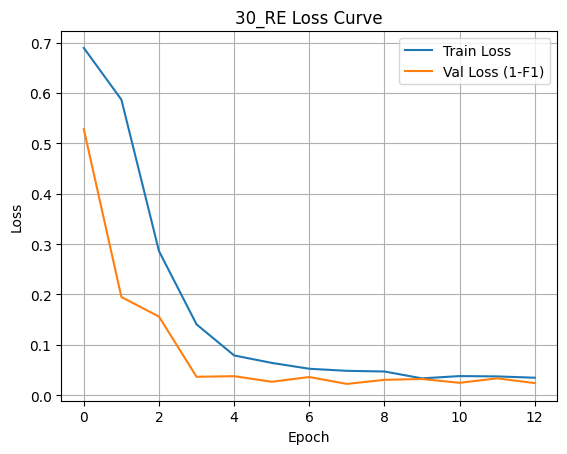

In [35]:
plt.figure()
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss (1-F1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('30_RE Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

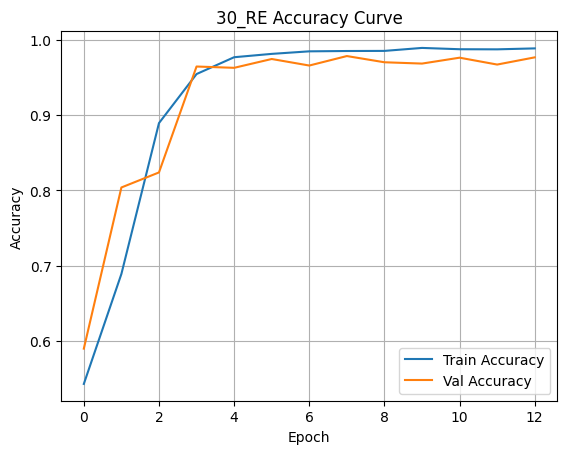

In [36]:
plt.figure()
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('30_RE Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

Test Results:
Test Accuracy: 0.9711
Test Precision: 0.9622
Test Recall: 0.9803
Test F1 Score: 0.9712


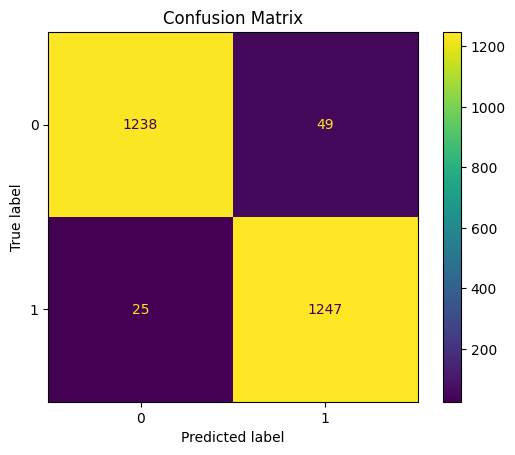

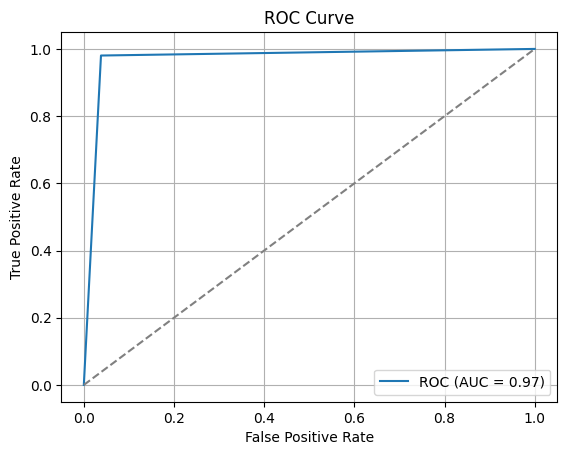

In [37]:
_, _, _, _, y_true_test, y_pred_test, _ = evaluate(model_30re, test_loader)
print_test_metrics(y_true_test, y_pred_test)